# Statistical Tests

## Import libraries

In [1]:
#!pip install statsmodels

In [2]:
#!pip install matplotlib

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import tt_ind_solve_power
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import median_test

import tqdm

## Importing data

In [4]:
df = pd.read_csv('bootstrap_homework.csv')

In [5]:
df.sample(5)

,passport_id,region,revenue,group
7085,132154477,Новосибирск,157,1
17728,123724400,Новосибирск,315,1
7722,141884827,Новосибирск,700,0
11288,142759334,Новосибирск,205,0
15147,132867339,Новосибирск,300,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32115 entries, 0 to 32114
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   passport_id  32115 non-null  int64 
 1   region       32115 non-null  object
 2   revenue      32115 non-null  int64 
 3   group        32115 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1003.7+ KB


In [7]:
df.isna().sum()

passport_id    0
region         0
revenue        0
group          0
dtype: int64

In [8]:
df.passport_id.nunique()

32115

In [9]:
df.group.value_counts()

1    16121
0    15994
Name: group, dtype: int64

In [10]:
df.group.value_counts(normalize=True)

1    0.501977
0    0.498023
Name: group, dtype: float64

In [11]:
df.revenue.describe()

count     32115.000000
mean       1561.262463
std        7687.990519
min         135.000000
25%         297.000000
50%         480.000000
75%        1332.000000
max      751925.000000
Name: revenue, dtype: float64

## Tasks

### Task 1.

 **Find the mean value of revenue for group 0.**

In [12]:
df[df['group'] == 0].revenue.mean()

1534.5570839064649

### Task 2.  

**Find the mean value of revenue for group 1.**

In [13]:
df[df['group'] == 1].revenue.mean()

1587.7574592146889

### Task 3.

**Calculate an absolute effect size.**

In [14]:
df[df['group'] == 1].revenue.mean() - df[df['group'] == 0].revenue.mean()

53.20037530822401

### Task 4. 

**What is the standardized effect size (Cohen D).**

In [15]:
uplift = df[df['group'] == 1].revenue.mean() - df[df['group'] == 0].revenue.mean()
sigma = df.revenue.std()

d = uplift / sigma

d

0.0069199324810495

### Task 5. 

**Calculate the sample size required to detect a 5% relative change in a two-tailed t-test with alpha = 0.05, power = 0.8. Use the data for group = 0 as the basis for calculating the necessary parameters (mean, lift, std).**

In [16]:
relative_uplift = 1.05
uplift = df[df['group'] == 0].revenue.mean() * relative_uplift - df[df['group'] == 0].revenue.mean()
sigma = df[df['group'] == 0].revenue.std()
d = uplift / sigma

sample_size = tt_ind_solve_power(effect_size = d,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided",
                       nobs1 = None)


print('Required sample size to detect desired relative uplift:', int(sample_size))

Required sample size to detect desired relative uplift: 162948


### Task 6. 

**Let's try to calculate the sample size using simulation to detect the same 5%, but using the Mann-Whitney U test.**

In [17]:
relative_uplift = 1.05
alpha = 0.05
beta = 0.2

sample_size_list = np.arange(800, 1600, 50)
iters = 1000
dct = dict()

data = df[df['group'] == 0].revenue

for ss in sample_size_list[:]:
    pvals = []
    for i in range(iters):
        a = np.random.choice(data, size=ss, replace=False)
        b = a * relative_uplift
        p_val = mannwhitneyu(a, b).pvalue
        pvals.append(p_val)
    effects = [x for x in pvals if x < alpha]
    power = len(effects) / len(pvals)
    dct[ss] = power

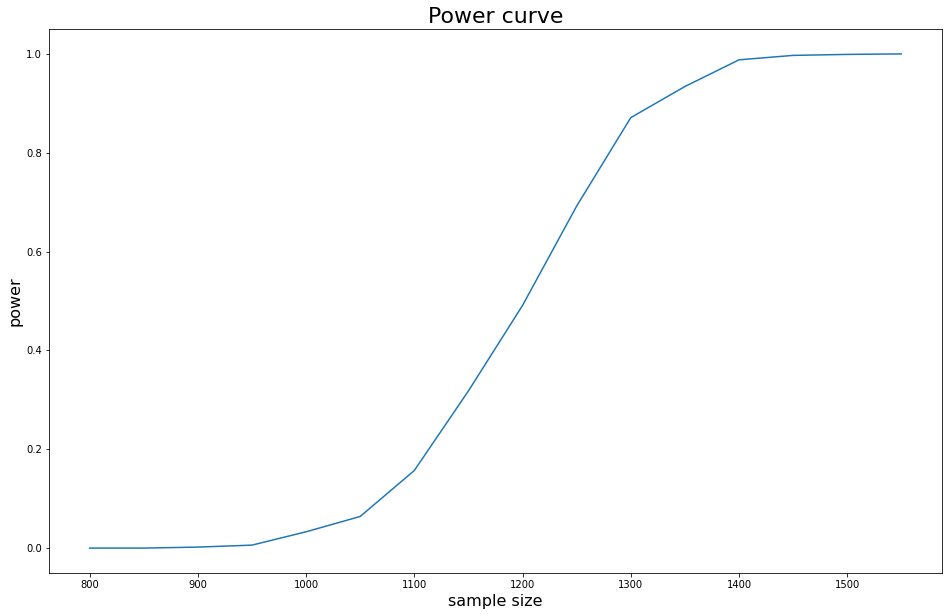

In [18]:
plt.figure(figsize=(16, 10))
plt.plot(dct.keys(), dct.values())

plt.xlabel('sample size', fontsize=16)
plt.ylabel('power', fontsize=16)
plt.title('Power curve', fontsize=22);

In [19]:
for k, v in dct.items():
    if v >= 1 - beta:
        print(f'Required sample size to detect desired relative uplift: {k}')
        break

Required sample size to detect desired relative uplift: 1300


### Task 7. 

**Calculate the sample size required to detect the observed effect found in Task 3 using a two-tailed t-test. With alpha = 0.05 and power = 0.8. Sample size is 50/50.**

In [20]:
uplift = df[df['group'] == 1].revenue.mean() - df[df['group'] == 0].revenue.mean()
sigma = df.revenue.std()

d = uplift / sigma

sample_size = tt_ind_solve_power(effect_size = d,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided",
                       nobs1 = None)


print('Required sample size to detect desired relative uplift:', round(sample_size))

Required sample size to detect desired relative uplift: 327819


### Task 8. 

**We have realized that the observed effect is less than the desired MDE, and the sample size is also less than the required size. Let's see what MDE we can afford with the available sample size when checking the difference in means using a two-tailed t-test. The test design parameters are the same.**

In [21]:
effect_size_d = tt_ind_solve_power(effect_size = None,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided",
                       nobs1 = df.shape[0]/2)

effect_size = effect_size_d * df.revenue.std()

effect_size

240.39149191318984

### Task 9. 

**Use simulations to define the test power using U Mann-Whitney test.**

In [22]:
alpha = 0.05
beta = 0.2
power = 1 - beta

relative_uplift = df[df['group'] == 1].revenue.mean() / df[df['group'] == 0].revenue.mean()
uplift = df[df['group'] == 1].revenue.mean() - df[df['group'] == 0].revenue.mean()
sigma = df.revenue.std()

d = uplift / sigma
 
hist_data = df[df['group'] == 0].revenue
    
print('Effect size =', d)
 
n_iter = 1000
print('Number of simulations = ', n_iter)
 
sample_size = 162948
print('Sample size = ', sample_size)
 
aa_control_group_means = []
aa_test_group_means = []
ab_control_group_means = []
ab_test_group_means = []
 
aa_p_val_list = []
aa_u_stat_list = []
aa_means_diffs_list = []
 
ab_p_val_list = []
ab_u_stat_list = []
ab_means_diffs_list = []
 
np.random.seed(1)
for i in tqdm.tqdm(range(n_iter)):
    sample_1 = np.random.choice(hist_data, size = sample_size)
    sample_2_zero_effect = np.random.choice(hist_data, size = sample_size)
    sample_2_with_effect = np.random.choice(hist_data, size = sample_size) * relative_uplift
 
    aa_control_group_means.append(sample_1.mean())
    aa_test_group_means.append(sample_2_zero_effect.mean())
 
    ab_control_group_means.append(sample_1.mean())
    ab_test_group_means.append(sample_2_with_effect.mean())
 
    aa_means_diff = sample_2_zero_effect.mean() - sample_1.mean()
    ab_means_diff = sample_2_with_effect.mean() - sample_1.mean()
 
    aa_u_stat, aa_p_val = mannwhitneyu(sample_2_zero_effect, sample_1)
    ab_u_stat, ab_p_val = mannwhitneyu(sample_2_with_effect, sample_1)
 
    aa_p_val_list.append(aa_p_val)
    ab_p_val_list.append(ab_p_val)
 
    aa_u_stat_list.append(aa_u_stat)
    ab_u_stat_list.append(ab_u_stat)
 
    aa_means_diffs_list.append(aa_means_diff)
    ab_means_diffs_list.append(ab_means_diff)

print('Test power after simulations:', (np.array(ab_p_val_list) < alpha).sum() / n_iter)

Effect size = 0.0069199324810495
Number of simulations =  1000
Sample size =  162948


100%|██████████| 1000/1000 [24:59<00:00,  1.50s/it]

Test power after simulations: 1.0


### Task 10. 

**Use simulations to define the test power using t-test.**

In [23]:
alpha = 0.05
beta = 0.2
power = 1 - beta

relative_uplift = df[df['group'] == 1].revenue.mean() / df[df['group'] == 0].revenue.mean()
uplift = df[df['group'] == 1].revenue.mean() - df[df['group'] == 0].revenue.mean()
sigma = df.revenue.std()

d = uplift / sigma
 
hist_data = df[df['group'] == 0].revenue
    
print('Effect size =', d)
 
n_iter = 1000
print('Number of simulations = ', n_iter)
 
sample_size = 162948
print('Sample size = ', sample_size)
 
aa_control_group_means = []
aa_test_group_means = []
ab_control_group_means = []
ab_test_group_means = []
 
aa_p_val_list = []
aa_u_stat_list = []
aa_means_diffs_list = []
 
ab_p_val_list = []
ab_u_stat_list = []
ab_means_diffs_list = []
 
np.random.seed(1)
for i in tqdm.tqdm(range(n_iter)):
    sample_1 = np.random.choice(hist_data, size = sample_size)
    sample_2_zero_effect = np.random.choice(hist_data, size = sample_size)
    sample_2_with_effect = np.random.choice(hist_data, size = sample_size) * relative_uplift

    aa_control_group_means.append(sample_1.mean())
    aa_test_group_means.append(sample_2_zero_effect.mean())
 
    ab_control_group_means.append(sample_1.mean())
    ab_test_group_means.append(sample_2_with_effect.mean())
 
    aa_means_diff = sample_2_zero_effect.mean() - sample_1.mean()
    ab_means_diff = sample_2_with_effect.mean() - sample_1.mean()
 
    aa_u_stat, aa_p_val = ttest_ind(sample_2_zero_effect, sample_1)
    ab_u_stat, ab_p_val = ttest_ind(sample_2_with_effect, sample_1)
 
    aa_p_val_list.append(aa_p_val)
    ab_p_val_list.append(ab_p_val)
 
    aa_u_stat_list.append(aa_u_stat)
    ab_u_stat_list.append(ab_u_stat)
 
    aa_means_diffs_list.append(aa_means_diff)
    ab_means_diffs_list.append(ab_means_diff)

print('Test power after simulations:', (np.array(ab_p_val_list) < alpha).sum() / n_iter)

Effect size = 0.0069199324810495
Number of simulations =  1000
Sample size =  162948


100%|██████████| 1000/1000 [00:19<00:00, 51.45it/s]

Test power after simulations: 0.464


### Task 11. 

**Test the hypothesis of equality of means using a two-tailed t-test. Specify the resulting p-value.**

In [24]:
ttest_ind(df[df['group'] == 0].revenue, df[df['group'] == 1].revenue)

Ttest_indResult(statistic=-0.620037942397532, pvalue=0.5352372067403763)

### Task 12. 

**Use U Mann-Whitney test on your data. Specify the resulting p-value.**

In [25]:
mannwhitneyu(df[df['group'] == 0].revenue, df[df['group'] == 1].revenue)

MannwhitneyuResult(statistic=137332553.5, pvalue=4.0824604776415004e-24)

### Task 13. 

**Apply Moods median test to your data.**

In [26]:
median_test(df[df['group'] == 0].revenue, df[df['group'] == 1].revenue)

MedianTestResult(statistic=108.81948173613007, pvalue=1.7775971068587562e-25, median=480.0, table=array([[8353, 7480],
       [7641, 8641]]))